In [1]:
import glob
from natsort import natsorted

s_dict = {'table_start': 0, 'hand_start': 1, 'off_start': 2}
fi_dict = {'nothing': 0, 'pasta': 1, 'rice': 2, 'water': 3}
fu_dict = {'zero': 0, 'fifty': 1, 'ninety': 2}
b_dict = {'regular': 0, 'textured': 1}
l_dict = {'light0': 0, 'light1': 1}
c_dict = {'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4}
obj_id_dict = {1: 'red cup', 2: 'small white cup',3:'small transparent cup',4:'green glass',5:'wine glass',
              6:'champagne flute glass', 7:'cereal box',8:'biscuit box',9:'tea box'} 

valid_dict = {'s': list(s_dict.keys()), 
              'fi': list(fi_dict.keys()),
              'fu': list(fu_dict.keys()),
              'b': list(b_dict.keys()),
              'l': list(l_dict.keys()),
              'c': list(c_dict.keys()),
              'obj_id': list(obj_id_dict.keys()),
             }

def retrieve_data(obj_id, s, fi, fu, b, l, c=[]):
    if ((fi == 'nothing' and (fu =='fifty' or fu =='ninety')) or (fi == 'pasta' and fu == 'zero') or (fi == 'rice' and fu=='zero') or (fi=='water' and fu=='zero')): 
        #print('error')
        return -1
    for i in range(1,len(c),1):
        if c[i] not in valid_dict['c']:
            return -1
    if  (obj_id not in obj_id_dict) or (s not in valid_dict['s']) or (fi not in valid_dict['fi']) or (fu not in valid_dict['fu']) or (b not in valid_dict['b']) or (l not in valid_dict['l']) :
        return -1
    
    _obj_id = obj_id
    _s_id = s_dict[s]
    _fi_id = fi_dict[fi]
    _fu_id = fu_dict[fu]
    _b_id = b_dict[b]
    _l_id = l_dict[l]
    _c_id = []
    
    for i in range(0,len(c),1):
        _c_id.append(c_dict[c[i]])
    if(len(c)==0):
        _c_id = [1,2,3,4]
        
    input_string = 's'+str(_s_id)+'_fi'+str(_fi_id)+'_fu'+str(_fu_id)+'_b'+str(_b_id)+'_l'+str(_l_id)
    
    audio_path = "./*Dataset/"+str(_obj_id)+"/audio/"+input_string+"*"
    audio_list = glob.glob(audio_path)[0]
    
    calib_list = []
    for i in range(0,len(_c_id),1):
        calib_path = "./*Dataset/"+str(_obj_id)+"/calib/"+input_string+'_c'+str(_c_id[i])+'*'
        calib_list.append(glob.glob(calib_path)[0])
    
    depth_list = []
    for i in range(0,len(_c_id),1):
        depth_path = "./*Dataset/"+str(_obj_id)+"/depth/"+input_string+'/c'+str(_c_id[i])+'/*'
        depth_list.append(natsorted(glob.glob(depth_path), key=lambda y: y.lower()))
        
    imu_path = "./*Dataset/"+str(_obj_id)+"/imu/"+input_string+"*"
    imu_list = tuple(glob.glob(imu_path))
    
    
    ir_list=[]
    for i in range(0,len(_c_id),1):
        ir_path = "./*Dataset/"+str(_obj_id)+"/ir/"+input_string+'_c'+str(_c_id[i])+'*'
        ir_list.append(glob.glob(ir_path))
    
    
    rgb_list = []
    for i in range(0,len(_c_id),1):
        rgb_path = "./*Dataset/"+str(_obj_id)+"/rgb/"+input_string+'_c'+str(_c_id[i])+'*'
        rgb_list.append(glob.glob(rgb_path)[0])
    
    
    output_dict = {'audio': audio_list,'calib':calib_list,'depth':depth_list,'imu':imu_list,'ir':ir_list,'rgb':rgb_list}
    return output_dict

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def computeObjectBoundingBox(depth_img_path, debug=False):
    # Define height limit to search, since bottom area is always a table
    HEIGHT_LIMIT = 600
    # Minimum area of the contours to be considered
    MIN_CONTOUR_AREA = 15000
    # In percentage (of bounding box)
    BBOX_EXPANSION = 1.05

    # Load image as uint16
    cv_img = cv2.imread(depth_img_path, -1)[:HEIGHT_LIMIT]

    if debug:
        # Show image
        plt.imshow(cv_img)
        plt.title("Original Depth Image")
        plt.show()

    # Find stats of image
    #mean = np.mean(cv_img)
    #std = np.std(cv_img)

    # Define distance threshold
    DIST_THRESHOLD = 700
    #DIST_THRESHOLD = mean - std

    # Filter pixels by distance threshold
    filter1 = np.where(cv_img < DIST_THRESHOLD, cv_img, 0)

    # Extract contours
    # Convert to unsigned 8-bit
    filter1_8u = ((filter1 / filter1.max()) * 255).astype(np.uint8)
    # Apply closing operation, try to retrieve some of the "missing" regions
    kernel = np.ones((15, 15), np.uint8)
    filter1_8u = cv2.morphologyEx(filter1_8u, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(filter1_8u, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        if debug:
            print("Couldn't find any contours")
            
        return cv_img, None

    if debug:
        viz_img = np.dstack([filter1_8u.copy(), filter1_8u.copy(), filter1_8u.copy()])

    # Iterate over contours, find the largest one
    #candidates = []
    bestContour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > MIN_CONTOUR_AREA and bestContour is None:
            bestContour = contour
        elif area > MIN_CONTOUR_AREA and bestContour is not None:
            # Use contour to find mask
            curr_cnt_mask = np.zeros(cv_img.shape, np.uint8)
            cv2.drawContours(curr_cnt_mask, [contour], 0, 255, -1)
            
            best_cnt_mask = np.zeros(cv_img.shape, np.uint8)
            cv2.drawContours(best_cnt_mask, [bestContour], 0, 255, -1)
            
            best_cnt_mean = cv2.mean(cv_img, mask=best_cnt_mask)
            curr_cnt_mean = cv2.mean(cv_img, mask=curr_cnt_mask)
            
            if curr_cnt_mean[0] < best_cnt_mean[0]:
                bestContour = contour
            
            if debug:
                plt.imshow(curr_cnt_mask, cmap='gray')
                plt.title("Current contour mask")
                plt.show()
                plt.imshow(best_cnt_mask, cmap='gray')
                plt.title("best contour mask")
                plt.show()            

    # Given the largest contour, find the bounding box
    if bestContour is not None:
        #print("Found object contour!")

        # If we found our object contour, find the bounding box
        x, y , w, h = cv2.boundingRect(bestContour)

    else:
        if debug:
            print("Couldn't determine object contour")
        return cv_img, None
    
    # Expand the bounding box a bit
    inc_w_h = int((w * BBOX_EXPANSION - w) / 2)
    inc_h_h = int((h * BBOX_EXPANSION - h) / 2)
    
    topx = x - inc_w_h
    topy = y - inc_h_h
    botx = x + w + inc_w_h
    boty = y + h + inc_h_h
    
    # Make sure values stay within range
    if topx < 0:
        topx = 0
    if topy < 0:
        topy = 0
    if botx > cv_img.shape[1]:
        botx = cv_img.shape[1]
    if boty > cv_img.shape[0]:
        boty = cv_img.shape[0]
    
    pt1 = (topx, topy)
    pt2 = (botx, boty)

    if debug:
        cv2.rectangle(viz_img, pt1, pt2, (255, 0, 0), 3)    

        cv2.drawContours(viz_img, contours, -1, (0, 255, 0), 2)

        plt.imshow(filter1)
        plt.title(f"Cropped to `DIST_THRESHOLD={DIST_THRESHOLD}` pixels")
        plt.show()

        plt.imshow(filter1_8u, cmap='gray')
        plt.title(f"Unsigned 8 image")
        plt.show()

        plt.imshow(viz_img, cmap='gray')
        plt.title(f"Viz image")
        plt.show()

    return cv_img, (filter1, pt1, pt2)
    
def findBestFrameROI(depth_imgs, search_max=30):
    _index = -1
    if len(depth_imgs) < search_max:
        search_n = len(depth_imgs) - 1
    else:
        search_n = search_max
        
    for _ in range(search_n):
        depth_img, ret = computeObjectBoundingBox(depth_imgs[_index], debug=False)
        
        #plt.imshow(depth_img)
        #plt.show()
        
        if ret != None:
            filter1, (topx, topy), (botx, boty) = ret

            roi = filter1[topy:boty, topx:botx]
            
            return roi

            #plt.imshow(filter1)
            #plt.show()

            #plt.imshow(roi)
            #plt.show()
            #print('#'*80)

        _index += -1
        
    #print("No roi for this sample.")
    return None
                     
# The capacity of the containers in mL
ANNOTATION = {1: 520.0, # Red cup
              2: 185.0, # Small white cup
              3: 202.0, # Small transparent cup
              4: 296.0, # Green glass
              5: 363.0, # Wine glass
              6: 128.0, # Champagne flute
              7: 3209.397, # Cereal box
              8: 1239.84, # Biscuits box
              9: 471.6} # Tea box

ANNOTATION_MEAN = 734.981888888889
ANNOTATION_STD = 929.7103190574344

IMG_WIDTH = 1280
IMG_HEIGHT = 720
MAX_VAL = 700 # Anything larger than this distance in the images, is discarded

total = 0
failed = 0
failed_samples = []

data = []
labels = []
for obj_id in range(1, 10):
    print(f"Extracting data from object id: `{obj_id}`")
    for sit in s_dict.keys():
        for fi in fi_dict.keys():
            for fu in fu_dict.keys():
                for b in b_dict.keys():
                    for l in l_dict.keys():
                        try:
                            sample = retrieve_data(obj_id, s=sit, fi=fi, fu=fu, b=b, l=l)
                        except Exception as e:
                            #print(f"Failed...: {(obj_id, sit, fi, fu, b, l)}")
                            pass
                        if sample != -1:
                            ret = findBestFrameROI(sample['depth'][2])
                            total += 1
                            if ret is None:
                                print(f"Failed for {sample['depth'][2][-1]}")
                                failed += 1
                                failed_samples.append((sit, fi, fu, b, l))
                            else:
                                # Add sample to dataset
                                roi_h, roi_w = ret.shape
                                
                                # Normalize ROI by max val
                                data.append((np.divide(ret, MAX_VAL), roi_h/IMG_HEIGHT, roi_w/IMG_WIDTH))

                                # Get label data
                                labels.append(ANNOTATION[obj_id] / 4000)

print(len(data), len(labels))
print(f"Out of {total} samples, {failed} failed to find object ROI")          

Extracting data from object id: `1`
Extracting data from object id: `2`
Extracting data from object id: `3`
Failed for ./Dataset/3/depth/s0_fi3_fu2_b0_l1/c3/0307.png
Extracting data from object id: `4`
Extracting data from object id: `5`


<ipython-input-2-58dd8f75e5c1>:35: RuntimeWarning: invalid value encountered in true_divide
  filter1_8u = ((filter1 / filter1.max()) * 255).astype(np.uint8)


Failed for ./Dataset/5/depth/s2_fi1_fu1_b0_l0/c3/0206.png
Failed for ./Dataset/5/depth/s2_fi1_fu2_b0_l0/c3/0335.png
Extracting data from object id: `6`
Extracting data from object id: `7`
Failed for ./Dataset/7/depth/s2_fi0_fu0_b1_l0/c3/0098.png
Failed for ./Dataset/7/depth/s2_fi1_fu1_b1_l0/c3/0100.png
Failed for ./Dataset/7/depth/s2_fi1_fu2_b1_l0/c3/0105.png
Failed for ./Dataset/7/depth/s2_fi2_fu1_b0_l0/c3/0139.png
Extracting data from object id: `8`
Failed for ./Dataset/8/depth/s2_fi1_fu1_b0_l0/c3/0140.png
Failed for ./Dataset/8/depth/s2_fi1_fu2_b0_l0/c3/0143.png
Failed for ./Dataset/8/depth/s2_fi2_fu1_b0_l0/c3/0134.png
Extracting data from object id: `9`
Failed for ./Dataset/9/depth/s2_fi1_fu1_b0_l0/c3/0132.png
Failed for ./Dataset/9/depth/s2_fi2_fu2_b0_l0/c3/0131.png
672 672
Out of 684 samples, 12 failed to find object ROI


In [3]:
# maximum_val = 0.0
# min_val = 10000000000
# for i in images:
#     _max = i.max()
#     _min = i.min()
#     if _max > maximum_val:
#         maximum_val = _max
#     if _min < min_val:
#         min_val = _min
        
# print(maximum_val, min_val)

[0.032      0.04625    0.0505     0.074      0.09075    0.1179
 0.13       0.30996    0.80234925] [84 84 83 84 82 58 84 57 56]


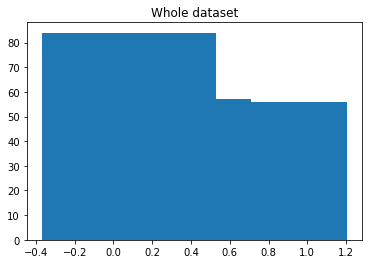

[0.032      0.04625    0.0505     0.074      0.09075    0.1179
 0.13       0.30996    0.80234925] [73 75 70 66 69 50 73 48 47]


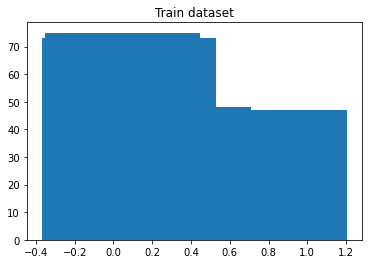

[0.032      0.04625    0.0505     0.074      0.09075    0.1179
 0.13       0.30996    0.80234925] [11  9 13 18 13  8 11  9  9]


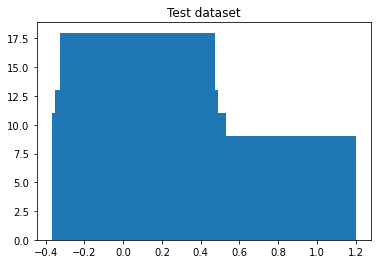

In [4]:
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import torch

NET_SIZE = (112, 112)

# Analyze class distribution and 
_classes, counts = np.unique(labels, return_counts=True)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Whole dataset")
plt.show()

# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                   test_size=0.15)

_classes, counts = np.unique(y_train, return_counts=True)
n_train_samples = len(y_train)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Train dataset")
plt.show()

_classes, counts = np.unique(y_test, return_counts=True)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Test dataset")
plt.show()

class VolumeDataset(Dataset):
    def __init__(self, x, y):
        self.images = []
        self.rois_size = []
        
        for _x in x:
            self.images.append(cv2.resize(_x[0], (112, 112)))
            self.rois_size.append((_x[1], _x[2]))
        
        self.y_volume = y
        
        assert len(self.images) == len(self.rois_size)
        assert len(self.images) == len(self.y_volume)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return (torch.Tensor(self.images[idx]).unsqueeze(0), torch.Tensor(self.rois_size[idx])), torch.Tensor([self.y_volume[idx]])
    
train_dataset = VolumeDataset(X_train, y_train)
test_dataset = VolumeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,
                          num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                          num_workers=0)

#for (img, roi_info), volume in test_loader:
#    print(img.shape)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
    
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=(3, 3),
                               padding=1,
                               stride=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=(3, 3),
                               padding=1,
                               stride=1)
        
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size=(3, 3),
                               padding=1,
                               stride=1)
        
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=(3, 3),
                               padding=1,
                               stride=1)
        
        self.bn4 = nn.BatchNorm2d(128)
        
        self.linear1 = nn.Linear(7*7*128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        
        self.linear2 = nn.Linear(64, 6)
        self.linear3 = nn.Linear(8, 1) # 6 + 2 roi_info features
        
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, img, roi_info):
        o1 = F.relu(self.conv1(img))
        o1 = self.pool(self.bn1(o1))
        #print(o1.shape)
        
        o2 = F.relu(self.conv2(o1))
        o2 = self.pool(self.bn2(o2))
        #print(o2.shape)
        
        o3 = F.relu(self.conv3(o2))
        o3 = self.pool(self.bn3(o3))
        #print(o3.shape)
        
        o4 = F.relu(self.conv4(o3))
        o4 = self.pool(self.bn4(o4))
        #print(o4.shape)

        # Keep batch dim and flatten
        conv_out = o4.view(-1, 7*7*128)
        
        l1 = F.relu(self.linear1(conv_out))
        l1 = self.bn5(l1)
        
        l2 = F.relu(self.linear2(l1))
        
        # Concat roi_info along with the processed conv features
        concat = torch.cat((l2, roi_info), 1)
        #print(l1[0])

        # Pay attention to the activation here
        out = self.linear3(concat)
        
        return out

INTERVAL = 15
    
model = ConvNet()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.00025)
criterion = nn.MSELoss()

for epoch in range(200):
    print(f"Epoch {epoch+1}")
    running_loss = 0.0
    model.train()
    for i_batch, batch in enumerate(train_loader):
        (x_img, x_roi_info), y_volume = batch[0], batch[1].cuda()
        x_img = x_img.cuda()
        x_roi_info = x_roi_info.cuda()
        
        assert len(x_img) == len(y_volume)

        optimizer.zero_grad()
        
        pred_y_volume = model(x_img, x_roi_info)
        
        loss = criterion(pred_y_volume, y_volume)
        #print(pred_y_volume.shape, y_volume.shape)
        #print(pred_y_volume[0], y_volume[0])
        
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if i_batch % INTERVAL == INTERVAL-1:
            running_loss += running_loss
            print(f"[{epoch+1}, {i_batch+1}]: MSE Loss: {running_loss/INTERVAL:.4f}")
            running_loss = 0.0
            
    if epoch % 10 == 9:
        test_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            model.eval()
            for batch in test_loader:
                (x_img, x_roi_info), y_volume = batch[0], batch[1].cuda()
                x_img = x_img.cuda()
                x_roi_info = x_roi_info.cuda()
                
                loss = criterion(pred_y_volume, y_volume)
                test_loss += loss.item()
                total_samples += 1
                
            test_loss = test_loss / total_samples
            
            print(f"Test Loss: {test_loss:.5f}")
            print("#"*40)

Epoch 1
[1, 15]: MSE Loss: 0.2461
[1, 30]: MSE Loss: 0.1579
[1, 45]: MSE Loss: 0.1360
[1, 60]: MSE Loss: 0.1265
Epoch 2
[2, 15]: MSE Loss: 0.0988
[2, 30]: MSE Loss: 0.0797
[2, 45]: MSE Loss: 0.0746
[2, 60]: MSE Loss: 0.0777
Epoch 3
[3, 15]: MSE Loss: 0.0657
[3, 30]: MSE Loss: 0.0579
[3, 45]: MSE Loss: 0.0508
[3, 60]: MSE Loss: 0.0619
Epoch 4
[4, 15]: MSE Loss: 0.0386
[4, 30]: MSE Loss: 0.0397
[4, 45]: MSE Loss: 0.0426
[4, 60]: MSE Loss: 0.0361
Epoch 5
[5, 15]: MSE Loss: 0.0352
[5, 30]: MSE Loss: 0.0285
[5, 45]: MSE Loss: 0.0248
[5, 60]: MSE Loss: 0.0279
Epoch 6
[6, 15]: MSE Loss: 0.0256
[6, 30]: MSE Loss: 0.0176
[6, 45]: MSE Loss: 0.0159
[6, 60]: MSE Loss: 0.0207
Epoch 7
[7, 15]: MSE Loss: 0.0167
[7, 30]: MSE Loss: 0.0150
[7, 45]: MSE Loss: 0.0143
[7, 60]: MSE Loss: 0.0182
Epoch 8
[8, 15]: MSE Loss: 0.0185
[8, 30]: MSE Loss: 0.0127
[8, 45]: MSE Loss: 0.0196
[8, 60]: MSE Loss: 0.0115
Epoch 9
[9, 15]: MSE Loss: 0.0207
[9, 30]: MSE Loss: 0.0240
[9, 45]: MSE Loss: 0.0245
[9, 60]: MSE Loss:

/home/ntnuerc/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[11, 15]: MSE Loss: 0.0152
[11, 30]: MSE Loss: 0.0157
[11, 45]: MSE Loss: 0.0210
[11, 60]: MSE Loss: 0.0152
Epoch 12
[12, 15]: MSE Loss: 0.0193
[12, 30]: MSE Loss: 0.0134
[12, 45]: MSE Loss: 0.0139
[12, 60]: MSE Loss: 0.0103
Epoch 13
[13, 15]: MSE Loss: 0.0112
[13, 30]: MSE Loss: 0.0209
[13, 45]: MSE Loss: 0.0156
[13, 60]: MSE Loss: 0.0139
Epoch 14
[14, 15]: MSE Loss: 0.0124
[14, 30]: MSE Loss: 0.0257
[14, 45]: MSE Loss: 0.0230
[14, 60]: MSE Loss: 0.0206
Epoch 15
[15, 15]: MSE Loss: 0.0120
[15, 30]: MSE Loss: 0.0118
[15, 45]: MSE Loss: 0.0162
[15, 60]: MSE Loss: 0.0129
Epoch 16
[16, 15]: MSE Loss: 0.0126
[16, 30]: MSE Loss: 0.0118
[16, 45]: MSE Loss: 0.0112
[16, 60]: MSE Loss: 0.0087
Epoch 17
[17, 15]: MSE Loss: 0.0086
[17, 30]: MSE Loss: 0.0086
[17, 45]: MSE Loss: 0.0100
[17, 60]: MSE Loss: 0.0133
Epoch 18
[18, 15]: MSE Loss: 0.0084
[18, 30]: MSE Loss: 0.0072
[18, 45]: MSE Loss: 0.0076
[18, 60]: MSE Loss: 0.0082
Epoch 19
[19, 15]: MSE Loss: 0.0077
[19, 30]: MSE Loss: 0.0080
[19, 45]: 

[78, 45]: MSE Loss: 0.0026
[78, 60]: MSE Loss: 0.0042
Epoch 79
[79, 15]: MSE Loss: 0.0081
[79, 30]: MSE Loss: 0.0024
[79, 45]: MSE Loss: 0.0032
[79, 60]: MSE Loss: 0.0064
Epoch 80
[80, 15]: MSE Loss: 0.0101
[80, 30]: MSE Loss: 0.0062
[80, 45]: MSE Loss: 0.0036
[80, 60]: MSE Loss: 0.0065
Test Loss: 0.05726
########################################
Epoch 81
[81, 15]: MSE Loss: 0.0071
[81, 30]: MSE Loss: 0.0050
[81, 45]: MSE Loss: 0.0046
[81, 60]: MSE Loss: 0.0048
Epoch 82
[82, 15]: MSE Loss: 0.0083
[82, 30]: MSE Loss: 0.0039
[82, 45]: MSE Loss: 0.0032
[82, 60]: MSE Loss: 0.0078
Epoch 83
[83, 15]: MSE Loss: 0.0034
[83, 30]: MSE Loss: 0.0087
[83, 45]: MSE Loss: 0.0033
[83, 60]: MSE Loss: 0.0057
Epoch 84
[84, 15]: MSE Loss: 0.0052
[84, 30]: MSE Loss: 0.0052
[84, 45]: MSE Loss: 0.0068
[84, 60]: MSE Loss: 0.0052
Epoch 85
[85, 15]: MSE Loss: 0.0050
[85, 30]: MSE Loss: 0.0052
[85, 45]: MSE Loss: 0.0043
[85, 60]: MSE Loss: 0.0045
Epoch 86
[86, 15]: MSE Loss: 0.0047
[86, 30]: MSE Loss: 0.0042
[86,

[143, 45]: MSE Loss: 0.0041
[143, 60]: MSE Loss: 0.0026
Epoch 144
[144, 15]: MSE Loss: 0.0050
[144, 30]: MSE Loss: 0.0026
[144, 45]: MSE Loss: 0.0087
[144, 60]: MSE Loss: 0.0041
Epoch 145
[145, 15]: MSE Loss: 0.0023
[145, 30]: MSE Loss: 0.0040
[145, 45]: MSE Loss: 0.0063
[145, 60]: MSE Loss: 0.0032
Epoch 146
[146, 15]: MSE Loss: 0.0046
[146, 30]: MSE Loss: 0.0032
[146, 45]: MSE Loss: 0.0015
[146, 60]: MSE Loss: 0.0031
Epoch 147
[147, 15]: MSE Loss: 0.0016
[147, 30]: MSE Loss: 0.0038
[147, 45]: MSE Loss: 0.0023
[147, 60]: MSE Loss: 0.0029
Epoch 148
[148, 15]: MSE Loss: 0.0043
[148, 30]: MSE Loss: 0.0030
[148, 45]: MSE Loss: 0.0066
[148, 60]: MSE Loss: 0.0113
Epoch 149
[149, 15]: MSE Loss: 0.0185
[149, 30]: MSE Loss: 0.0121
[149, 45]: MSE Loss: 0.0055
[149, 60]: MSE Loss: 0.0064
Epoch 150
[150, 15]: MSE Loss: 0.0035
[150, 30]: MSE Loss: 0.0034
[150, 45]: MSE Loss: 0.0099
[150, 60]: MSE Loss: 0.0040
Test Loss: 0.17478
########################################
Epoch 151
[151, 15]: MSE Loss:

[208, 15]: MSE Loss: 0.0031
[208, 30]: MSE Loss: 0.0023
[208, 45]: MSE Loss: 0.0042
[208, 60]: MSE Loss: 0.0050
Epoch 209
[209, 15]: MSE Loss: 0.0092
[209, 30]: MSE Loss: 0.0037
[209, 45]: MSE Loss: 0.0036
[209, 60]: MSE Loss: 0.0022
Epoch 210
[210, 15]: MSE Loss: 0.0025
[210, 30]: MSE Loss: 0.0028
[210, 45]: MSE Loss: 0.0024
[210, 60]: MSE Loss: 0.0066
Test Loss: 0.06577
########################################
Epoch 211
[211, 15]: MSE Loss: 0.0036
[211, 30]: MSE Loss: 0.0020
[211, 45]: MSE Loss: 0.0034
[211, 60]: MSE Loss: 0.0029
Epoch 212
[212, 15]: MSE Loss: 0.0023
[212, 30]: MSE Loss: 0.0023
[212, 45]: MSE Loss: 0.0033
[212, 60]: MSE Loss: 0.0023
Epoch 213
[213, 15]: MSE Loss: 0.0022
[213, 30]: MSE Loss: 0.0031
[213, 45]: MSE Loss: 0.0040
[213, 60]: MSE Loss: 0.0029
Epoch 214
[214, 15]: MSE Loss: 0.0029
[214, 30]: MSE Loss: 0.0028
[214, 45]: MSE Loss: 0.0018
[214, 60]: MSE Loss: 0.0028
Epoch 215
[215, 15]: MSE Loss: 0.0021
[215, 30]: MSE Loss: 0.0021
[215, 45]: MSE Loss: 0.0024
[2

[272, 30]: MSE Loss: 0.0015
[272, 45]: MSE Loss: 0.0023
[272, 60]: MSE Loss: 0.0031
Epoch 273
[273, 15]: MSE Loss: 0.0021
[273, 30]: MSE Loss: 0.0011
[273, 45]: MSE Loss: 0.0016
[273, 60]: MSE Loss: 0.0027
Epoch 274
[274, 15]: MSE Loss: 0.0020
[274, 30]: MSE Loss: 0.0024
[274, 45]: MSE Loss: 0.0012
[274, 60]: MSE Loss: 0.0023
Epoch 275
[275, 15]: MSE Loss: 0.0019
[275, 30]: MSE Loss: 0.0041
[275, 45]: MSE Loss: 0.0029
[275, 60]: MSE Loss: 0.0014
Epoch 276
[276, 15]: MSE Loss: 0.0056
[276, 30]: MSE Loss: 0.0014
[276, 45]: MSE Loss: 0.0022
[276, 60]: MSE Loss: 0.0015
Epoch 277
[277, 15]: MSE Loss: 0.0031
[277, 30]: MSE Loss: 0.0023
[277, 45]: MSE Loss: 0.0035
[277, 60]: MSE Loss: 0.0021
Epoch 278
[278, 15]: MSE Loss: 0.0025
[278, 30]: MSE Loss: 0.0018
[278, 45]: MSE Loss: 0.0027
[278, 60]: MSE Loss: 0.0007
Epoch 279
[279, 15]: MSE Loss: 0.0012
[279, 30]: MSE Loss: 0.0019
[279, 45]: MSE Loss: 0.0021
[279, 60]: MSE Loss: 0.0016
Epoch 280
[280, 15]: MSE Loss: 0.0019
[280, 30]: MSE Loss: 0.0

[337, 15]: MSE Loss: 0.0015
[337, 30]: MSE Loss: 0.0040
[337, 45]: MSE Loss: 0.0019
[337, 60]: MSE Loss: 0.0013
Epoch 338
[338, 15]: MSE Loss: 0.0018
[338, 30]: MSE Loss: 0.0010
[338, 45]: MSE Loss: 0.0014
[338, 60]: MSE Loss: 0.0019
Epoch 339
[339, 15]: MSE Loss: 0.0018
[339, 30]: MSE Loss: 0.0016
[339, 45]: MSE Loss: 0.0025
[339, 60]: MSE Loss: 0.0014
Epoch 340
[340, 15]: MSE Loss: 0.0013
[340, 30]: MSE Loss: 0.0025
[340, 45]: MSE Loss: 0.0015
[340, 60]: MSE Loss: 0.0024
Test Loss: 0.04969
########################################
Epoch 341
[341, 15]: MSE Loss: 0.0026
[341, 30]: MSE Loss: 0.0012
[341, 45]: MSE Loss: 0.0013
[341, 60]: MSE Loss: 0.0011
Epoch 342
[342, 15]: MSE Loss: 0.0015
[342, 30]: MSE Loss: 0.0022
[342, 45]: MSE Loss: 0.0028
[342, 60]: MSE Loss: 0.0010
Epoch 343
[343, 15]: MSE Loss: 0.0011
[343, 30]: MSE Loss: 0.0017
[343, 45]: MSE Loss: 0.0010
[343, 60]: MSE Loss: 0.0018
Epoch 344
[344, 15]: MSE Loss: 0.0014
[344, 30]: MSE Loss: 0.0030
[344, 45]: MSE Loss: 0.0025
[3

[401, 30]: MSE Loss: 0.0011
[401, 45]: MSE Loss: 0.0020
[401, 60]: MSE Loss: 0.0016
Epoch 402
[402, 15]: MSE Loss: 0.0022
[402, 30]: MSE Loss: 0.0012
[402, 45]: MSE Loss: 0.0021
[402, 60]: MSE Loss: 0.0011
Epoch 403
[403, 15]: MSE Loss: 0.0010
[403, 30]: MSE Loss: 0.0020
[403, 45]: MSE Loss: 0.0023
[403, 60]: MSE Loss: 0.0013
Epoch 404
[404, 15]: MSE Loss: 0.0019
[404, 30]: MSE Loss: 0.0017
[404, 45]: MSE Loss: 0.0076
[404, 60]: MSE Loss: 0.0011
Epoch 405
[405, 15]: MSE Loss: 0.0020
[405, 30]: MSE Loss: 0.0013
[405, 45]: MSE Loss: 0.0007
[405, 60]: MSE Loss: 0.0021
Epoch 406
[406, 15]: MSE Loss: 0.0019
[406, 30]: MSE Loss: 0.0017
[406, 45]: MSE Loss: 0.0053
[406, 60]: MSE Loss: 0.0030
Epoch 407
[407, 15]: MSE Loss: 0.0022
[407, 30]: MSE Loss: 0.0013
[407, 45]: MSE Loss: 0.0011
[407, 60]: MSE Loss: 0.0023
Epoch 408
[408, 15]: MSE Loss: 0.0006
[408, 30]: MSE Loss: 0.0019
[408, 45]: MSE Loss: 0.0018
[408, 60]: MSE Loss: 0.0014
Epoch 409
[409, 15]: MSE Loss: 0.0015
[409, 30]: MSE Loss: 0.0

[465, 60]: MSE Loss: 0.0019
Epoch 466
[466, 15]: MSE Loss: 0.0011
[466, 30]: MSE Loss: 0.0025
[466, 45]: MSE Loss: 0.0013
[466, 60]: MSE Loss: 0.0021
Epoch 467
[467, 15]: MSE Loss: 0.0023
[467, 30]: MSE Loss: 0.0016
[467, 45]: MSE Loss: 0.0015
[467, 60]: MSE Loss: 0.0025
Epoch 468
[468, 15]: MSE Loss: 0.0028
[468, 30]: MSE Loss: 0.0021
[468, 45]: MSE Loss: 0.0020
[468, 60]: MSE Loss: 0.0019
Epoch 469
[469, 15]: MSE Loss: 0.0018
[469, 30]: MSE Loss: 0.0009
[469, 45]: MSE Loss: 0.0016
[469, 60]: MSE Loss: 0.0017
Epoch 470
[470, 15]: MSE Loss: 0.0010
[470, 30]: MSE Loss: 0.0024
[470, 45]: MSE Loss: 0.0025
[470, 60]: MSE Loss: 0.0017
Test Loss: 0.04838
########################################
Epoch 471
[471, 15]: MSE Loss: 0.0025
[471, 30]: MSE Loss: 0.0022
[471, 45]: MSE Loss: 0.0023
[471, 60]: MSE Loss: 0.0013
Epoch 472
[472, 15]: MSE Loss: 0.0021
[472, 30]: MSE Loss: 0.0009
[472, 45]: MSE Loss: 0.0014
[472, 60]: MSE Loss: 0.0013
Epoch 473
[473, 15]: MSE Loss: 0.0043
[473, 30]: MSE Loss:

In [58]:
def getModelPrediction(model, depth_frames):
    roi = findBestFrameROI(depth_frames)
    
    if roi is not None:
        h, w = roi.shape
        h = h / IMG_HEIGHT
        w = w / IMG_WIDTH
        
        # Normalize and resize roi
        roi = np.divide(roi, MAX_VAL)
        roi = cv2.resize(roi, NET_SIZE)
        
        # Convert everything to tensors
        tensor_roi = torch.Tensor(roi).unsqueeze(0)
        tensor_roi = tensor_roi.unsqueeze(0).cuda()
        tensor_roi_info = torch.Tensor([h, w]).unsqueeze(0).cuda()

        # Feed to model and get prediction
        with torch.no_grad():
            pred = model(tensor_roi, tensor_roi_info)
            return pred.item() * 4000 #* ANNOTATION_STD) + ANNOTATION_MEAN
    else:
        print("Couldnt find roi")
        return None
        
model.eval()
preds = []
for i in range(60):
    i_str = str(i)
    _str = '0' * (4 - len(i_str)) + i_str
    sample_frames = natsorted(glob.glob(f'Dataset/12/depth/{_str}/c3/*.png'))

    pred = getModelPrediction(model, sample_frames)
    if pred is not None:
        preds.append(pred)
   
    
    
    
np.mean(preds)

<ipython-input-2-58dd8f75e5c1>:35: RuntimeWarning: invalid value encountered in true_divide
  filter1_8u = ((filter1 / filter1.max()) * 255).astype(np.uint8)


Couldnt find roi
Couldnt find roi
Couldnt find roi
Couldnt find roi


1417.132227548531

In [7]:
# The capacity of the containers in mL
ANNOTATION = {1: 520.0, # Red cup
              2: 185.0, # Small white cup
              3: 202.0, # Small transparent cup
              4: 296.0, # Green glass
              5: 363.0, # Wine glass
              6: 128.0, # Champagne flute
              7: 3209.397, # Cereal box
              8: 1239.84, # Biscuits box
              9: 471.6} # Tea box

vals = list(ANNOTATION.values())
print(vals)

mean = np.mean(vals)
std = np.std(vals)
print(mean, std)

normalized = (vals - mean) / std
print(normalized)

[520.0, 185.0, 202.0, 296.0, 363.0, 128.0, 3209.397, 1239.84, 471.6]
734.981888888889 929.7103190574344
[-0.23123535 -0.59156264 -0.57327737 -0.47217061 -0.40010515 -0.65287206
  2.66149042  0.54302733 -0.28329457]


In [8]:
import pandas as pd
def generatesubmission(feature,data_list):
    df = pd.read_csv('submissions/submissionfile.csv',index_col=0)
    df[feature] = data_list
    df.to_csv('./submissions/submissionfile.csv')

In [59]:
Container_Capacity_dic = {10:453.84929329156876,11:467.14714401728145,12:1417.132227548531}
data_list=[]
df = pd.read_csv('submissions/submissionfile.csv')
for j in range(10,13):
    for i in range((df['Container ID']==j).sum()):
        data_list.append(Container_Capacity_dic[j])
len(data_list)
print(data_list)

[453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876, 453.84929329156876,

In [61]:
generatesubmission('Container Capacity',data_list)

In [50]:
print(len(preds))
print(preds)

60
[1871.9310760498047, 1284.316062927246, 1461.5625143051147, 1879.4474601745605, 1661.1031293869019, 856.5754890441895, 1017.8735256195068, 1748.9001750946045, 1391.5421962738037, 1616.925597190857, 2383.138656616211, 1197.2930431365967, 1147.6399898529053, 1003.0750036239624, -1, 1350.6317138671875, 1389.357566833496, 1069.688081741333, 2054.701805114746, 1056.5693378448486, 2179.6462535858154, 1559.289574623108, 855.7561039924622, -1, 1801.5096187591553, 1219.1458940505981, 2135.6592178344727, 988.2728457450867, 1192.911148071289, 787.0398759841919, 1180.8658838272095, 1690.1371479034424, 1123.9075660705566, 1801.6518354415894, 1684.5309734344482, 1046.358585357666, 1222.6459980010986, 789.4732356071472, 1922.737717628479, 2352.247714996338, 1021.5753316879272, 1737.982988357544, 1548.818826675415, 1177.6173114776611, 1697.1685886383057, -1, 1578.3904790878296, 1542.87850856781, -1, 1863.6950254440308, 1114.0027046203613, 1112.0328903198242, 1040.4130220413208, 1299.3124723434448, 

In [42]:
data_list=[]

In [51]:
data_list+=preds
data_list

[314.41840529441833,
 184.81141328811646,
 370.24587392807007,
 508.09550285339355,
 307.7709972858429,
 385.80507040023804,
 454.88622784614563,
 332.1031928062439,
 226.83916985988617,
 -1,
 310.99146604537964,
 236.20569705963135,
 792.6722168922424,
 367.5205111503601,
 170.29240727424622,
 465.75915813446045,
 381.3762068748474,
 562.5863671302795,
 350.2958118915558,
 404.23738956451416,
 296.13450169563293,
 238.06118965148926,
 820.4612731933594,
 438.13449144363403,
 375.08848309516907,
 161.4813208580017,
 992.7847385406494,
 469.58357095718384,
 450.14268159866333,
 545.3451871871948,
 291.20680689811707,
 453.5031318664551,
 493.6419129371643,
 620.7624077796936,
 414.500892162323,
 276.5718698501587,
 551.2747764587402,
 507.04532861709595,
 282.9831838607788,
 310.60516834259033,
 512.2324228286743,
 734.8564267158508,
 376.46883726119995,
 348.9348888397217,
 263.36294412612915,
 445.7263946533203,
 694.770097732544,
 754.7130584716797,
 481.89595341682434,
 876.62196159

In [52]:
len(data_list)

228